# Welcome!

We've got some issues we want to resolve.

- [ ] First, we need to fix the data itself. Right now, there are invalid values for some data points (zero or negative) which get pruned off. Because of this, all of the ANOVAs are throwing errors about unbalanced data. We should remove `type = 1` for all `ezANOVA` calls once this is done.
- [ ] Second, we should gather all that data into a readable format that can be placed into the python graph for "Comparing Relative Performance of Docker"

# Getting Started

In this section, we import the necessary packages and load/transform our data.

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

# For adding R code to the notebook
import rpy2
%load_ext rpy2.ipython

First, we load in the Docker and native data into arrays of pandas dataframes.

In [2]:
docker_dfs = []
native_dfs = []

# EDIT THESE TWO ARRAYS TO ADD YOUR TEST DATA
folders = ['GZ__Ubuntu__Xeon_E3-1290_V2_3.7GHz_x8__8GB_RAM', 'linux-lt215', 'linux-loaner002', 'GZ__Mac__i9_2.3GHz_x8__16GB_RAM', 'osx-macmini180', 'windows-lt215', 'windows-loaner002']
devices = ['Ubuntu 1', 'Ubuntu 2', 'Ubuntu 3', 'Mac 1', 'Mac 2', 'Windows 1', 'Windows 2']
oss = ['Ubuntu', 'Ubuntu', 'Ubuntu', 'macOS', 'macOS', 'Windows', 'Windows']

for idx, f in enumerate(folders):
  docker_dfs += [[]] # Append empty list
  native_dfs += [[]]
  for i in range(10):
    docker_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/docker-{i}.csv')]
    native_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/native-{i}.csv')]

Next, we combine and reorganize the dataframes into the format below. This format makes it easy to manipulate.

| Device                | Condition | Batch | Run | Benchmark | Source Video | Image Path | Kernel Width (# pixels) | Time Elapsed (milliseconds) | CPU Usage (% of CPU) | Memory Usage (% of memory) |
|-----------------------|-----------|-------|-----|-----------|--------------|------------|-------------------------|-----------------------------|----------------------|----------------------------|
| Macbook Pro 16 (2019) | Docker    | 1     | 1   | resize    | Video 1      | ./path     | 3                       | 55.213                      | 25.0                 | 9.1                        |

In [6]:
# We're going to arrange everything in a massive 2D list
all_dfs_list = []
s = set()

for idx, d in enumerate(devices):    
  # First, get the docker dfs
  for df_index in range(10):
    for _, row in docker_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Docker',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

  # Second, get the native dfs
  for df_index in range(10):
    for _, row in native_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Native',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

print('The following benchmarks have missing values because of negative numbers:', s)

# Finally, make the dataframe to put the data
all_df = pd.DataFrame(data=all_dfs_list, columns=[
  'Device',
  'Operating System',
  'Condition',
  'Batch',
  'Run',
  'Trial', # the overall trial (unique ID)
  'Benchmark',
  'Source Video',
  'Image Path',
  'Kernel Width (# pixels)',
  'Runtime (milliseconds)',
  'LogTime',
  'CPU Usage (% of CPU)',
  'Memory Usage (% of memory)'
])

The following benchmarks have missing values because of negative numbers: {'gaussianBlur', 'resize'}


In [7]:
all_df.head()

,Device,Operating System,Condition,Batch,Run,Trial,Benchmark,Source Video,Image Path,Kernel Width (# pixels),Runtime (milliseconds),LogTime,CPU Usage (% of CPU),Memory Usage (% of memory)
0,Ubuntu 1,Ubuntu,Docker,1,1,1,measureMemoryUsage,Video4,./data/Video4/Chess6.png and 9 others,3,29.633760,1.471787,4.2,18.6
1,Ubuntu 1,Ubuntu,Docker,1,2,2,measureMemoryUsage,Video4,./data/Video4/Chess6.png and 9 others,3,11.155367,1.047484,11.1,19.7
2,Ubuntu 1,Ubuntu,Docker,1,3,3,measureMemoryUsage,Video4,./data/Video4/Chess6.png and 9 others,3,11.100054,1.045325,20.0,19.9
3,Ubuntu 1,Ubuntu,Docker,1,4,4,measureMemoryUsage,Video4,./data/Video4/Chess6.png and 9 others,3,11.120081,1.046108,11.1,20.1
4,Ubuntu 1,Ubuntu,Docker,1,5,5,measureMemoryUsage,Video4,./data/Video4/Chess6.png and 9 others,3,11.128902,1.046452,11.1,20.2


# Time

R[write to console]: 
Attaching package: ‘janitor’


R[write to console]: The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




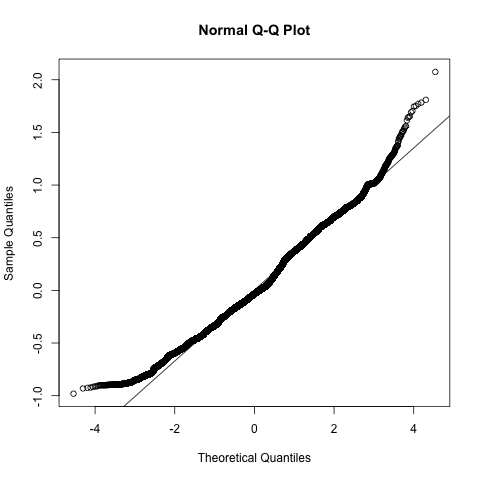

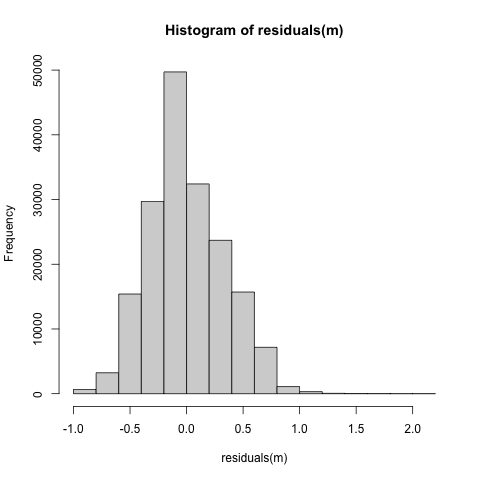

In [8]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)

# Use a QQ plot and histogram to check normality
m = aov(log_time ~ condition*benchmark, data=all_df)
qqnorm(residuals(m))
qqline(residuals(m))
hist(residuals(m))

# Anovas

In this section, we perform a series of stats in order to determine whether the differences are significant for various comparisons.

We have the following set of questions we want to ask:
1. Two-way ANOVA with three independent variables: Docker vs Native, Benchmark, and OS. This probably won't show anything useful and it will probably hide a lot of valuable information, but it's a start.
2. For each benchmark, do a two-way ANOVA with two variables: Docker vs Native and OS. This shows any interaction effect.
3. For each benchmark and OS (that's `NUM_OSs * NUM_BENCHMARKS`—it's a lot of tests!), do a one-way ANOVA considering just Docker vs Native. This shows if there is a signficant difference for each column of the massive relative performance graph showing all benches/OSs.

In [9]:
%%R -i all_df

library(tidyverse) # Used for filtering out data irrelevant to a given test
library(janitor) # Fix dataframe column names to sanitize
# Libraries for the ezANOVA
library(ez)
library(apa)
library(lsr)
all_df <- clean_names(all_df)

all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$source_video <- factor(all_df$source_video)
all_df$kernel_width_number_pixels <- factor(all_df$kernel_width_number_pixels)

# print(head(all_df))

# type=1 only if we removed stuff
anoResults <- ezANOVA(data=all_df, type=1, dv=log_time, wid=device, within=c(condition, benchmark), between=operating_system)
print(anoResults)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects 

$ANOVA
                                Effect DFn DFd            F            p p<.05
1                     operating_system   2   4 2.988844e+00 1.607164e-01      
2                            condition   1   4 4.383431e-02 8.443928e-01      
4                            benchmark  15  60 1.296434e+03 1.941394e-69     *
3           operating_system:condition   2   4 7.025021e+00 4.910928e-02     *
5           operating_system:benchmark  30  60 2.419256e+00 1.810514e-03     *
6                  condition:benchmark  15  60 1.993158e+01 7.116473e-18     *
7 operating_system:condition:benchmark  30  60 7.142540e+00 6.550338e-11     *
           ges
1 0.4781878572
2 0.0002799351
4 0.9890070678
3 0.0823597303
5 0.2513704903
6 0.2941954607
7 0.2300225889



## Significance of Docker on Each Benchmark

The following does a TON of anovas (one for each comparison we want to make). The reason this is done as a crapload of separate anovas instead of a single beast is because we can only do a Tukey on a single variable, making it kinda useless for our use case. We want to know if, for each benchmark & os, docker changes performance. So, that's a lot of combinations and each one needs a test somehow!

If somebody knows how to do this better, you are welcome to refactor this. Otherwise, this should calculate everything we need. It does not do all the checks it ought to regarding normality, etc, which may be a weakness.

In [12]:
%%R -i all_df -o significance

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double()) 

for (b in levels(all_df$benchmark)) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    print(ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system))
#     m = aov(log_time ~ condition * operating_system, data=bench_df)
#     print(summary(m))
#     print(summary(glht(m, linfct = mcp(condition="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual ANOVAs for each benchmark and OS
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        m = aov(log_time ~ condition, data=os_bench_df)
        m_summary = summary(m)
        print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        
        significance[nrow(significance) + 1,] = list(b, os, m_summary[[1]][[1,"Pr(>F)"]])
    }
}

print(head(significance))


[1] "------------------------------------------------------------"
[1] "brightnessRandomization"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  3.435983 0.135364172       0.6124865
2                  condition   1   4 40.288140 0.003156052     * 0.4462123
3 operating_system:condition   2   4 21.599804 0.007181963     * 0.4635119

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    5.7   5.670   50.99 1.14e-12 ***
Residuals   3198  355.6   0.111                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.3 0.25413   3.596  0.058 .
Residuals   4798  339.1 0.07067                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F va

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F         p p<.05         ges
1           operating_system   2   4 2.270961 0.2192849       0.524423552
2                  condition   1   4 1.152247 0.3435219       0.008244692
3 operating_system:condition   2   4 3.891061 0.1152585       0.053161631

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    6.0   5.957   36.23 1.96e-09 ***
Residuals   3198  525.9   0.164                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0  0.0023   0.016  0.899
Residuals   4798  691.5  0.1441               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.6  0.6054     4.3 0.0382 *
Residuals   319

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05         ges
1           operating_system   2   4 2.4171815 0.20500738       0.532805293
2                  condition   1   4 0.4802848 0.52642901       0.006725584
3 operating_system:condition   2   4 6.4510579 0.05600642       0.153901762

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1   0.19 0.18581   5.369 0.0206 *
Residuals   3198 110.68 0.03461                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   10.5  10.480   105.9 <2e-16 ***
Residuals   4798  474.6   0.099                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F valu

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05        ges
1           operating_system   2   4 3.426719 0.13582675       0.60340935
2                  condition   1   4 1.602741 0.27422655       0.04294325
3 operating_system:condition   2   4 9.043901 0.03279556     * 0.33615843

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1    6.3   6.296   105.8 <2e-16 ***
Residuals   3198  190.4   0.060                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value  Pr(>F)   
condition      1   0.49  0.4893   7.428 0.00644 **
Residuals   4798 316.05  0.0659                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05       ges
1           operating_system   2   4   2.822344 0.1720060162       0.5805830
2                  condition   1   4  87.463692 0.0007279427     * 0.2942652
3 operating_system:condition   2   4 138.465966 0.0002027299     * 0.5690043

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    1.3  1.3046    13.8 0.000206 ***
Residuals   3198  302.3  0.0945                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0 0.00000       0  0.999
Residuals   4798  332.3 0.06925               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  201.4  201.36    2870 <2e-16 ***

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F         p p<.05        ges
1           operating_system   2   4 1.8129764 0.2751261       0.45923036
2                  condition   1   4 3.4682529 0.1360339       0.05193601
3 operating_system:condition   2   4 0.9443174 0.4614140       0.02896691

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0 0.04048   0.391  0.532
Residuals   3198  330.9 0.10348               
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    4.8   4.829   44.93 2.27e-11 ***
Residuals   4798  515.6   0.107                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.3  0.2707   2.502  0.114
Residuals   3198  3

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05        ges
1           operating_system   2   4  4.112390 0.107062607       0.67158661
2                  condition   1   4 29.535321 0.005562738     * 0.03883832
3 operating_system:condition   2   4  8.397072 0.037003079     * 0.02246025

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1    9.3   9.323   77.29 <2e-16 ***
Residuals   3198  385.8   0.121                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.1 0.09235   0.675  0.411
Residuals   4798  656.7 0.13688               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    5.4   5.409   49.08 2.99e-12 ***
Resid

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F         p p<.05          ges
1           operating_system   2   4 2.13695872 0.2337209       0.5143109885
2                  condition   1   4 2.29611931 0.2042754       0.0051037582
3 operating_system:condition   2   4 0.07710178 0.9271381       0.0003443996

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.1 0.09889   0.764  0.382
Residuals   3197  414.1 0.12952               
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.5  0.4653   2.729 0.0986 .
Residuals   4798  818.1  0.1705                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.4   0.438   2.433  0.119
Residuals   3198  5

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F           p p<.05       ges
1           operating_system   2   4  4.34526 0.099348452       0.6679072
2                  condition   1   4 15.05364 0.017842768     * 0.2185158
3 operating_system:condition   2   4 34.05223 0.003077483     * 0.5585024

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    3.4   3.359   33.32 8.58e-09 ***
Residuals   3198  322.4   0.101                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)  
condition      1    0.3 0.26908   3.189 0.0742 .
Residuals   4798  404.8 0.08438                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05      ges
1           operating_system   2   4  6.767442 0.052037237       0.741887
2                  condition   1   4  4.915280 0.090910741       0.156125
3 operating_system:condition   2   4 30.262038 0.003843053     * 0.694946

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  24.99  24.992     376 <2e-16 ***
Residuals   3198 212.58   0.066                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    2.1  2.1039   32.91 1.02e-08 ***
Residuals   4798  306.7  0.0639                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F           p p<.05       ges
1           operating_system   2   4   3.534798 0.130573930       0.6074674
2                  condition   1   4 128.554111 0.000344974     * 0.7999033
3 operating_system:condition   2   4   5.355101 0.073940553       0.2498405

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   35.4   35.36   266.4 <2e-16 ***
Residuals   3198  424.4    0.13                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  258.0  258.02    2890 <2e-16 ***
Residuals   4798  428.3    0.09                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05       ges
1           operating_system   2   4 6.851362 0.05105517       0.7146793
2                  condition   1   4 7.243035 0.05458503       0.3273909
3 operating_system:condition   2   4 2.435552 0.20331279       0.2466185

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   9.76   9.762   119.8 <2e-16 ***
Residuals   3198 260.69   0.082                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    4.1   4.126   54.27 2.05e-13 ***
Residuals   4798  364.8   0.076                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F valu

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05       ges
1           operating_system   2   4   3.932148 0.1136674211       0.6586507
2                  condition   1   4 119.576932 0.0003972130     * 0.3570532
3 operating_system:condition   2   4  95.582383 0.0004200656     * 0.4702847

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   30.2  30.204   519.8 <2e-16 ***
Residuals   3198  185.8   0.058                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1    1.5  1.5258   22.25 2.46e-06 ***
Residuals   4798  329.0  0.0686                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum S

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F         p p<.05       ges
1           operating_system   2   4 1.550663 0.3172788       0.3199946
2                  condition   1   4 4.832780 0.0928224       0.3219872
3 operating_system:condition   2   4 2.083902 0.2398333       0.2905555

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value   Pr(>F)    
condition      1   3.14  3.1396    44.8 2.57e-11 ***
Residuals   3198 224.13  0.0701                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  217.4  217.40    1896 <2e-16 ***
Residuals   4798  550.3    0.11                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  2.444595 0.202486312       0.5409534
2                  condition   1   4 15.466628 0.017063288     * 0.1218657
3 operating_system:condition   2   4 18.664826 0.009366913     * 0.2509078

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  49.67   49.67    1913 <2e-16 ***
Residuals   3196  82.97    0.03                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1    0.0 0.00225   0.043  0.836
Residuals   4798  252.6 0.05264               
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)
condition      1   0.02 0.02208   0.286  0.593
Residuals   3198 246.

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05        ges
1           operating_system   2   4 0.8562214 0.49031621       0.26176066
2                  condition   1   4 0.5318004 0.50625687       0.02232692
3 operating_system:condition   2   4 6.9705747 0.04970722     * 0.37447876

[1] "--------------------------OS:  macOS ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1  20.17  20.175   237.5 <2e-16 ***
Residuals   3198 271.69   0.085                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Ubuntu ---------------------------"
              Df Sum Sq Mean Sq F value Pr(>F)    
condition      1   20.3   20.31   253.3 <2e-16 ***
Residuals   4798  384.7    0.08                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "--------------------------OS:  Windows ---------------------------"
              Df Sum Sq Mean Sq F va

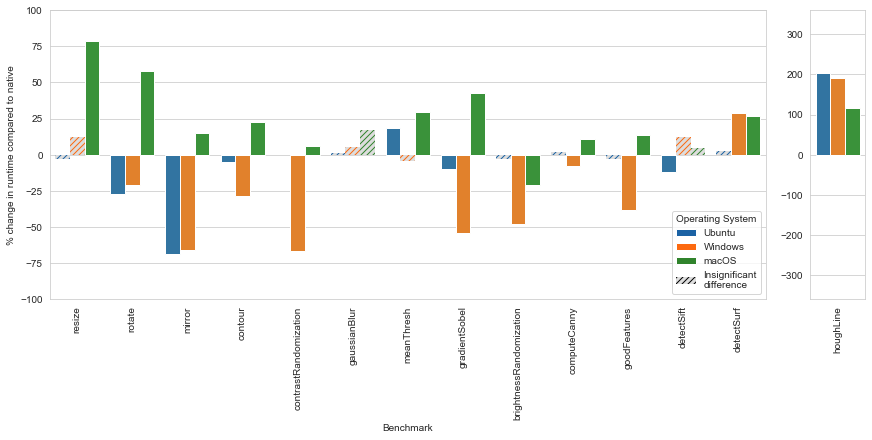

In [13]:
# print(significance.head())

sns.set_style("whitegrid")

all_means = all_df.groupby(['Benchmark', 'Operating System', 'Condition']).mean()

# Gets % diff compared to native
perf_ratios = all_means.groupby(['Benchmark', 'Operating System']).apply(
    lambda d : (d.loc[ : , : , 'Docker'] / d.loc[ : , : , 'Native'] - 1) * 100
)
# Fix the naming of the performance ratio for runtime
perf_ratios.rename(inplace=True, columns={
    'Runtime (milliseconds)': '% change in runtime compared to native'
})
# Fix a random problem with the index
perf_ratios = perf_ratios.reset_index(level=[1,2], drop=True).reset_index()

# Turn the benchmark into a category so we can sort it
perf_ratios['Benchmark'] = perf_ratios['Benchmark'].astype('category')

# Ready for plotting
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(12)
fig.set_figheight(6)
widths=[13, 1]
yMax = [100, 360]
yMin = [-100, -360]
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
benchSets = [
  ['resize', 'rotate', 'mirror', 'contour', 'contrastRandomization',
   'gaussianBlur', 'meanThresh', 'gradientSobel',
   'brightnessRandomization', 'computeCanny', 'goodFeatures',
   'detectSift', 'detectSurf'],
  ['houghLine']
]
oss = ['Ubuntu', 'Windows', 'macOS']
colors = ['#1b62a4', '#fc6910', '#30832c']

# Make the axes
axes = []
for col in range(2):
  axes += [fig.add_subplot(gs[0, col])]

# For each subset of benchmarks, draw it and have fun!
for col, benches in enumerate(benchSets):
  ratios_subset = perf_ratios[perf_ratios['Benchmark'].isin(benches)]
  
  # Sort the benchmarks because they're probably out of order now
  ratios_subset['Benchmark'].cat.set_categories(benches, inplace=True)
  ratios_subset.sort_values(['Benchmark'])

  b = sns.barplot(
      x='Benchmark', y='% change in runtime compared to native',
      hue='Operating System', hue_order=oss,
      data=ratios_subset, ax=axes[col],
  )
    
  for i, bar in enumerate(b.patches):
    # Get the benchmark and os for this bar using math
    curr_bench = benchSets[col][i % len(benches)]
    os = oss[i // len(benches)]
    
    # If the difference is insignificant, make the bar gray
    if significance[(significance['benchmark'] == curr_bench) & (significance['os'] == os)].iloc[0]['p'] > 0.05:
      bar.set(color='#DDD', linewidth=0, edgecolor=colors[i // len(benches)], hatch='////')
#       bar.set_hatch('xxxx')

  axes[col].set_xticklabels(axes[col].get_xticklabels(), rotation=90)

  # Set the y limit
  axes[col].set_ylim(ymax=yMax[col], ymin=yMin[col])

  # Only first subfig has axes and legend
  if col != 0:
    axes[col].get_legend().set_visible(False)
    axes[col].set_ylabel(None)
    axes[col].set_xlabel(None)

legend_elements = []
legend_labels = oss + ['Insignificant\ndifference']
for i, os in enumerate(oss):
  legend_elements += [patches.Patch(facecolor=colors[i])]
legend_elements += [patches.Patch(facecolor='#DDD', hatch='////', edgecolor='#000', linewidth=0)]
#   plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#1b62a4', markersize=10, label='Ubuntu'),
#   plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#fc6910', markersize=10, label='Windows'),
#   plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#30832c', markersize=10, label='macOS'),
#   # plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#279221', markersize=10, label='Windows 1'),
#   # plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#ca101f', markersize=10, label='Windows 2'),
#   plt.Line2D([0], [0], marker='s', color='w', markeredgewidth=2, markersize=7, label=''),
#   plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#DDD', markersize=10, label='Insignificant\ndifference'),
# ]
axes[0].legend(legend_elements, legend_labels, loc='lower right', title='Operating System')